In [64]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,Adagrad,RMSprop
from sklearn.model_selection import train_test_split
import pandas as pd
folder_path = "outside_test/256"
import matplotlib.pyplot as plt

In [4]:
# cuda check
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.is_gpu_available():
    print("Default GPU Device:", tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Please install GPU version of TF


## Loading dataset


In [35]:
# Loading dataste
data_dir = 'dataset_full'

# Define the class names and their corresponding directories
class_names = ['class1', 'class0']

# Create a list to store image paths and labels
image_paths = []
labels = []

# Iterate over the class directories
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for root, _, filenames in os.walk(class_dir):
        for filename in filenames:
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_paths.append(os.path.join(root, filename))
                labels.append(i)

# Convert the image paths and labels to TensorFlow Dataset
image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
##----------------------------------------------------------------------------------
# Load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))  
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

dataset = tf.data.Dataset.zip((image_paths_ds, labels_ds))
dataset = dataset.map(load_and_preprocess_image)
dataset = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=False)

##----------------------------------------------------------------------------------
# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(image_paths))
val_size = int(0.15 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

# Split the data 
train_image_paths, temp_image_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=val_size+test_size, random_state=42
)
val_image_paths, test_image_paths, val_labels, test_labels = train_test_split(
    temp_image_paths, temp_labels, test_size=float(test_size) / (val_size + test_size), random_state=42
)

# Create TensorFlow Datasets 
train_image_paths_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)
val_image_paths_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)
val_labels_ds = tf.data.Dataset.from_tensor_slices(val_labels)
test_image_paths_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels)

# Load and preprocess images for training, validation, and test datasets
train_dataset = tf.data.Dataset.zip((train_image_paths_ds, train_labels_ds))
train_dataset = train_dataset.map(load_and_preprocess_image)

val_dataset = tf.data.Dataset.zip((val_image_paths_ds, val_labels_ds))
val_dataset = val_dataset.map(load_and_preprocess_image)

test_dataset = tf.data.Dataset.zip((test_image_paths_ds, test_labels_ds))
test_dataset = test_dataset.map(load_and_preprocess_image)

# Convert labels to one hot
num_classes = len(class_names)
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_dataset = val_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

# Batches
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
 


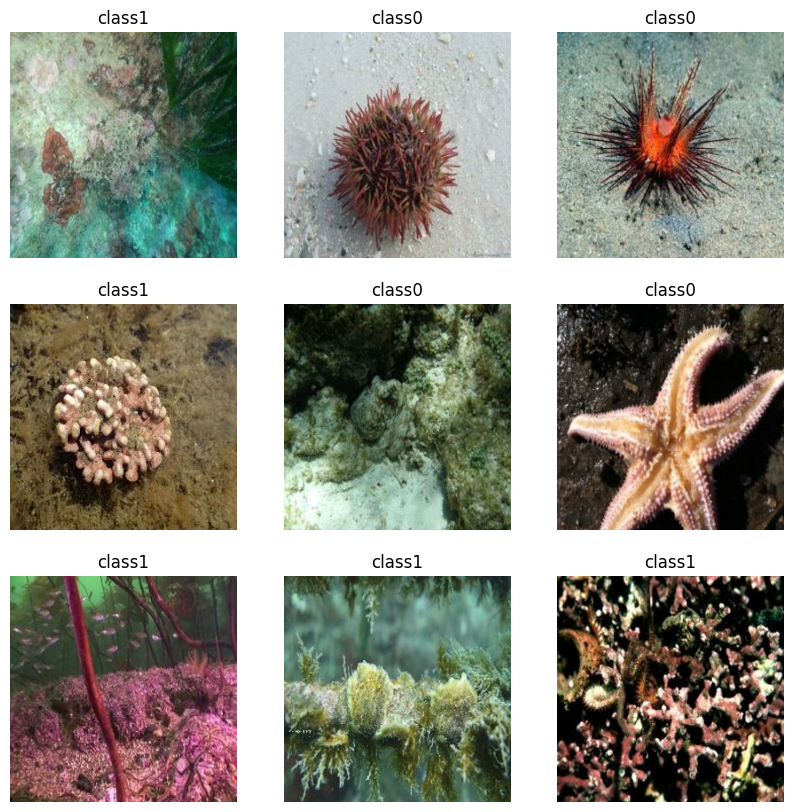

In [6]:
# Chequing dataset load
def deprocess_vgg16(img):
    mean = [103.939, 116.779, 123.68]
    img = img + mean  
    return img[..., ::-1]  

def normalize_image(img):
    img_min = tf.reduce_min(img)
    img_max = tf.reduce_max(img)
    return (img - img_min) / (img_max - img_min)

def visualize_dataset(dataset, class_names):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)        
            deprocessed_image = deprocess_vgg16(images[i])
            normalized_image = normalize_image(deprocessed_image)  
            plt.imshow(normalized_image.numpy())
            plt.title(class_names[tf.argmax(labels[i]).numpy()])
            plt.axis("off")
        plt.show()

visualize_dataset(train_dataset, class_names)

# Training

### VGG Finetuning 

In [41]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  #  trainable weights false for big LR true to keep prefeatures

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_v_c = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

learning_rate = 1e-4  
#optimizer = Adam(learning_rate=learning_rate)
optimizer = Adagrad(learning_rate=learning_rate)
model_v_c.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)

#model_v_c.load_weights('weights/vgg16_weights_0.h5')  #coment for restart training from 0


In [42]:
history_vgg = model_v_c.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[es]
)

model_v_c.save_weights('vgg16_weights_1.h5')

Epoch 1/10
35/35 [==============================] - 212s 6s/step - loss: 1.2896 - accuracy: 0.6795 - precision: 0.6795 - recall: 0.6795 - val_loss: 0.7617 - val_accuracy: 0.7741 - val_precision: 0.7741 - val_recall: 0.7741
Epoch 2/10
35/35 [==============================] - 219s 6s/step - loss: 0.3521 - accuracy: 0.8827 - precision: 0.8827 - recall: 0.8827 - val_loss: 0.6622 - val_accuracy: 0.7992 - val_precision: 0.7992 - val_recall: 0.7992
Epoch 3/10
35/35 [==============================] - 219s 6s/step - loss: 0.1978 - accuracy: 0.9311 - precision: 0.9311 - recall: 0.9311 - val_loss: 0.6240 - val_accuracy: 0.8117 - val_precision: 0.8117 - val_recall: 0.8117
Epoch 4/10
35/35 [==============================] - 218s 6s/step - loss: 0.1276 - accuracy: 0.9534 - precision: 0.9534 - recall: 0.9534 - val_loss: 0.5984 - val_accuracy: 0.8117 - val_precision: 0.8117 - val_recall: 0.8117
Epoch 5/10
35/35 [==============================] - 236s 7s/step - loss: 0.0930 - accuracy: 0.9696 - precisi

In [43]:
# Convert the history object to a DataFrame and save 
history_df = pd.DataFrame(history_vgg.history)
file_exists = os.path.exists('outputs//training_history_vgg3.csv')
history_df.to_csv('outputs//training_history_vgg3.csv', mode='a', header=not file_exists, index=False)


In [44]:

test_metrics = model_v_c.evaluate(test_dataset)
test_metrics_df = pd.DataFrame([test_metrics], columns=model_v_c.metrics_names)
test_metrics_df.to_csv('outputs//test_metrics_vgg2.csv', index=False)

8/8 [==============================] - 61s 8s/step - loss: 0.6320 - accuracy: 0.8083 - precision: 0.8083 - recall: 0.8083


8/8 [==============================] - 29s 4s/step - loss: 0.4731 - accuracy: 0.9417 - precision: 0.9417 - recall: 0.9417
first training 


## Funcion de test sobre 12 imagenes de holdout

In [20]:
#ouside test def 
def outside_test(model):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            img_path = os.path.join(folder_path, filename)
            predicted_class = predict_image_class(img_path, model, class_names)
            print(f"{filename} -> Predicted Class: {predicted_class}")


def predict_image_class(img_path, model, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_batch)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    return class_names[predicted_class_idx]


In [21]:
outside_test(model_v_c)

1/1 [==============================] - 1s 1s/step
1.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 149ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 154ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 148ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 152ms/step
5.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 147ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 150ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 153ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 154ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 148ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 148ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s

### Restnet Finetuning

In [65]:
# Loading ResNet50 model
base_model_restnet = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_restnet.trainable = False  
global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_r = models.Sequential([
    base_model_restnet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

learning_rate = 1e-4  
optimizer = Adam(learning_rate=learning_rate)
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_r.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics
)

es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=5, restore_best_weights=True)

In [23]:
history_restnet = model_r.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[es]
)

model_r.save_weights('weights//restnet_weights2.h5')

Epoch 1/10
35/35 [==============================] - 110s 3s/step - loss: 0.6151 - accuracy: 0.6714 - precision: 0.6714 - recall: 0.6714 - val_loss: 0.4660 - val_accuracy: 0.8285 - val_precision: 0.8285 - val_recall: 0.8285
Epoch 2/10
35/35 [==============================] - 103s 3s/step - loss: 0.3296 - accuracy: 0.9006 - precision: 0.9006 - recall: 0.9006 - val_loss: 0.2859 - val_accuracy: 0.8996 - val_precision: 0.8996 - val_recall: 0.8996
Epoch 3/10
35/35 [==============================] - 103s 3s/step - loss: 0.2098 - accuracy: 0.9329 - precision: 0.9329 - recall: 0.9329 - val_loss: 0.2154 - val_accuracy: 0.9205 - val_precision: 0.9205 - val_recall: 0.9205
Epoch 4/10
35/35 [==============================] - 103s 3s/step - loss: 0.1594 - accuracy: 0.9445 - precision: 0.9445 - recall: 0.9445 - val_loss: 0.1797 - val_accuracy: 0.9289 - val_precision: 0.9289 - val_recall: 0.9289
Epoch 5/10
35/35 [==============================] - 104s 3s/step - loss: 0.1291 - accuracy: 0.9597 - precisi

In [24]:
history_restnet_df = pd.DataFrame(history_restnet.history)
history_restnet_df.to_csv('training_history_restnet2.csv', index=False)


In [26]:

test_metrics_restnet = model_r.evaluate(test_dataset)
test_metrics_restnet_df = pd.DataFrame([test_metrics_restnet], columns=model_r.metrics_names)
test_metrics_restnet_df.to_csv('test_metrics_restnet.csv', index=False)

8/8 [==============================] - 22s 3s/step - loss: 0.1386 - accuracy: 0.9542 - precision: 0.9542 - recall: 0.9542


In [68]:
model_r.load_weights('weights/restnet_weights_2.h5') 
outside_test(model_r)

1/1 [==============================] - 0s 136ms/step
1.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 136ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 127ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 133ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 148ms/step
5.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 143ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 145ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 147ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 148ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 146ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 159ms/step
_5.jpeg -> Predicted Class: class1
1/1 [==============================] -

### Desnsenet Finetuning

In [72]:
#train densenet
num_classes = 2  

base_model_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_densenet.trainable = False  

global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_d = models.Sequential([
    base_model_densenet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
    
    
learning_rate = 1e-4  
optimizer = Adam(learning_rate=learning_rate)
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
    

model_d.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics
)

es = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=2, restore_best_weights=True)


In [73]:
#new train 
history_densenet = model_d.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[es]
)

model_d.save_weights('densenet_weights3.h5')


Epoch 1/10
35/35 [==============================] - 134s 4s/step - loss: 1.6570 - accuracy: 0.5801 - precision: 0.5801 - recall: 0.5801 - val_loss: 1.1152 - val_accuracy: 0.6234 - val_precision: 0.6234 - val_recall: 0.6234
Epoch 2/10
35/35 [==============================] - 124s 4s/step - loss: 0.8645 - accuracy: 0.6598 - precision: 0.6598 - recall: 0.6598 - val_loss: 0.8681 - val_accuracy: 0.6485 - val_precision: 0.6485 - val_recall: 0.6485
Epoch 3/10
35/35 [==============================] - 128s 4s/step - loss: 0.6472 - accuracy: 0.7037 - precision: 0.7037 - recall: 0.7037 - val_loss: 0.7066 - val_accuracy: 0.6946 - val_precision: 0.6946 - val_recall: 0.6946
Epoch 4/10
35/35 [==============================] - 126s 4s/step - loss: 0.5453 - accuracy: 0.7377 - precision: 0.7377 - recall: 0.7377 - val_loss: 0.6294 - val_accuracy: 0.7071 - val_precision: 0.7071 - val_recall: 0.7071
Epoch 5/10
35/35 [==============================] - 125s 4s/step - loss: 0.4874 - accuracy: 0.7780 - precisi

In [74]:
#history_restnet_df = history_restnet.head(8)
# Convert the history object to a DataFrame
history_densenet_df = pd.DataFrame(history_densenet.history)
history_densenet_df.to_csv('training_history_densenet3.csv', index=False)
test_metrics_densenet = model_d.evaluate(test_dataset)
test_metrics_densenet_df = pd.DataFrame([test_metrics_densenet], columns=model_d.metrics_names)
test_metrics_densenet_df.to_csv('test_metrics_densenet3.csv', index=False)

8/8 [==============================] - 22s 3s/step - loss: 0.4413 - accuracy: 0.7833 - precision: 0.7833 - recall: 0.7833


In [76]:
#model_d.load_weights('weights//densenet_weights_3.h5') 
outside_test(model_d)

1/1 [==============================] - 2s 2s/step
1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 157ms/step
2.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 151ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 153ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 155ms/step
5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 156ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 151ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 150ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 154ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 154ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 158ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s

## Historia de entrenamiento

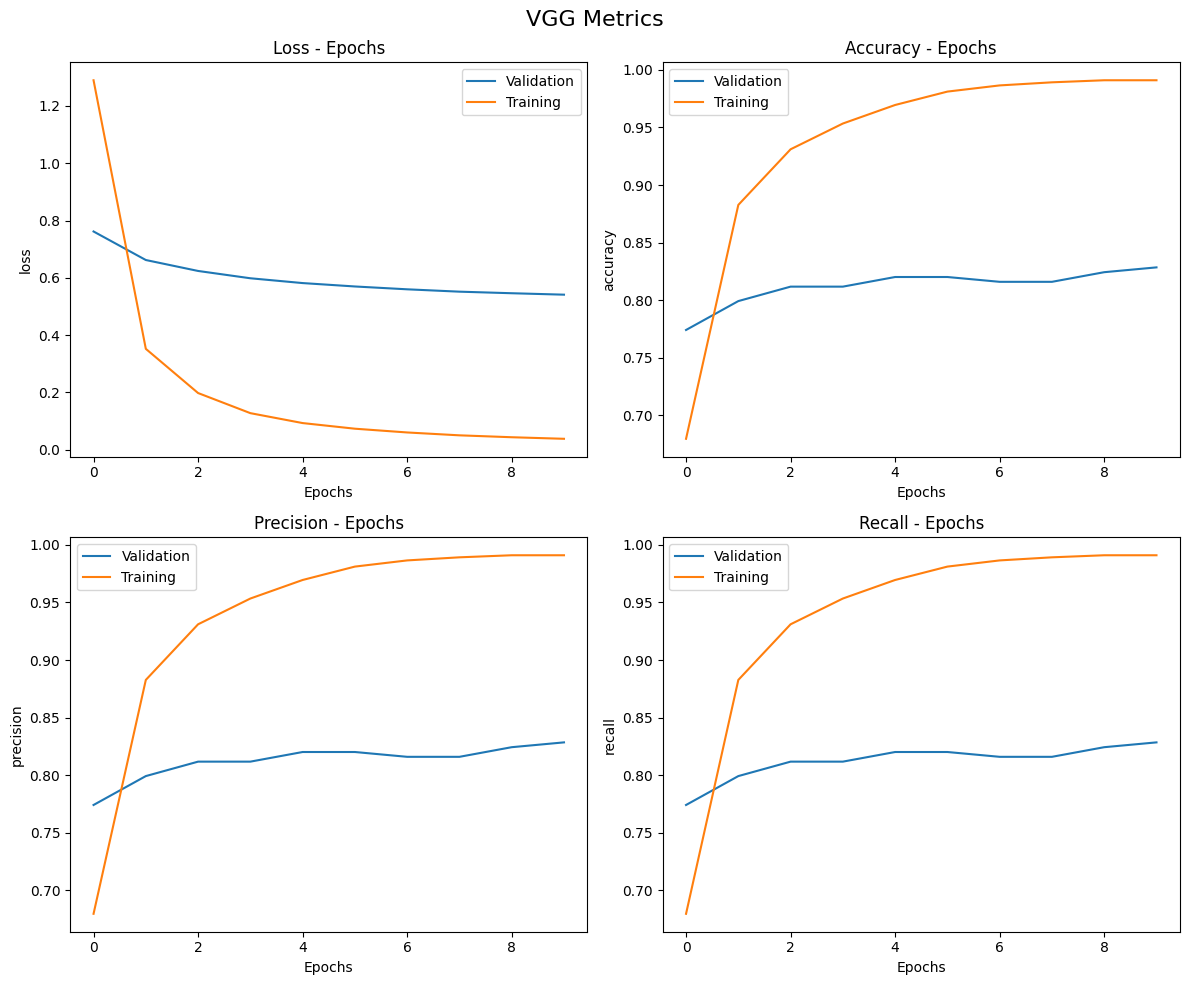

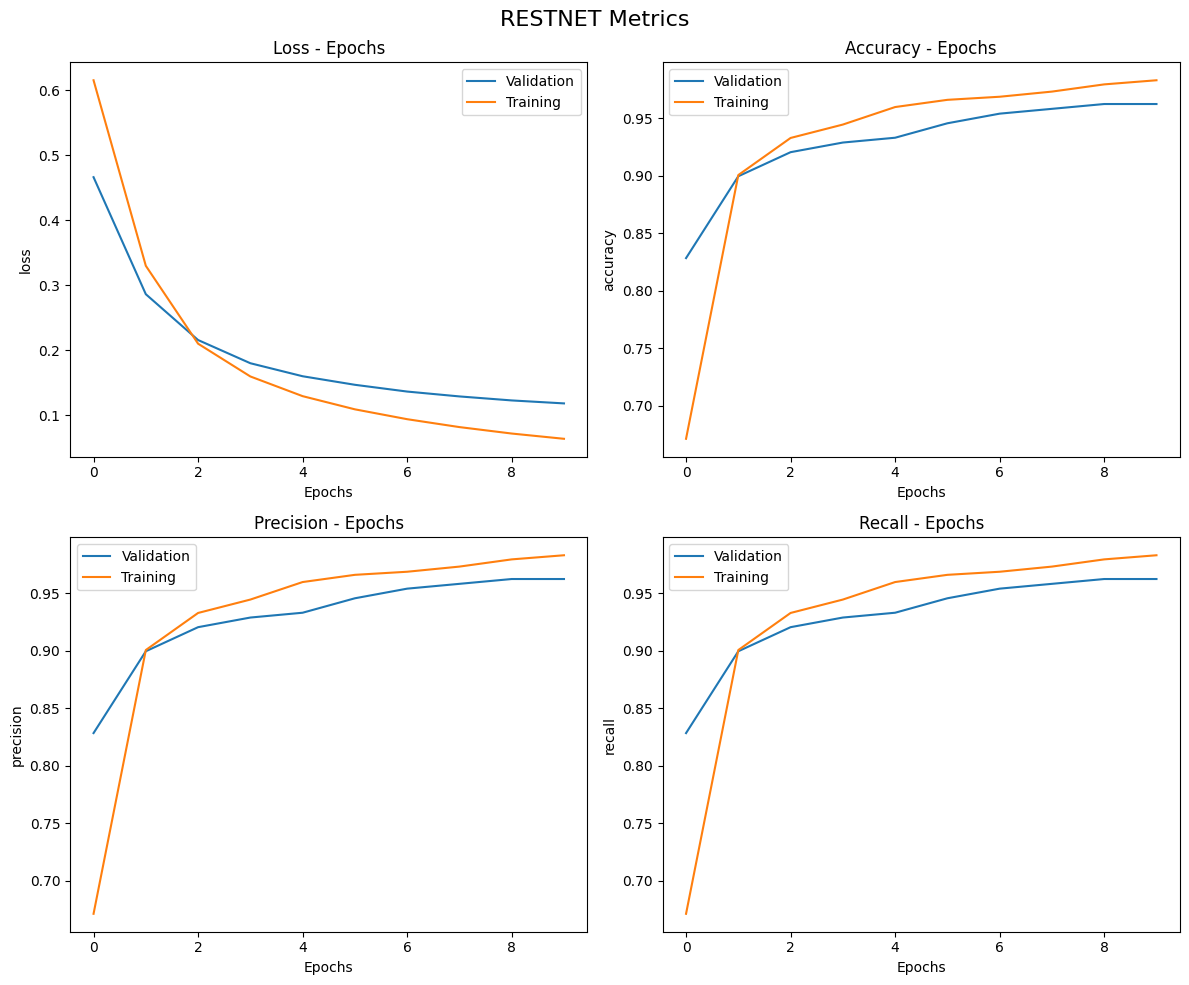

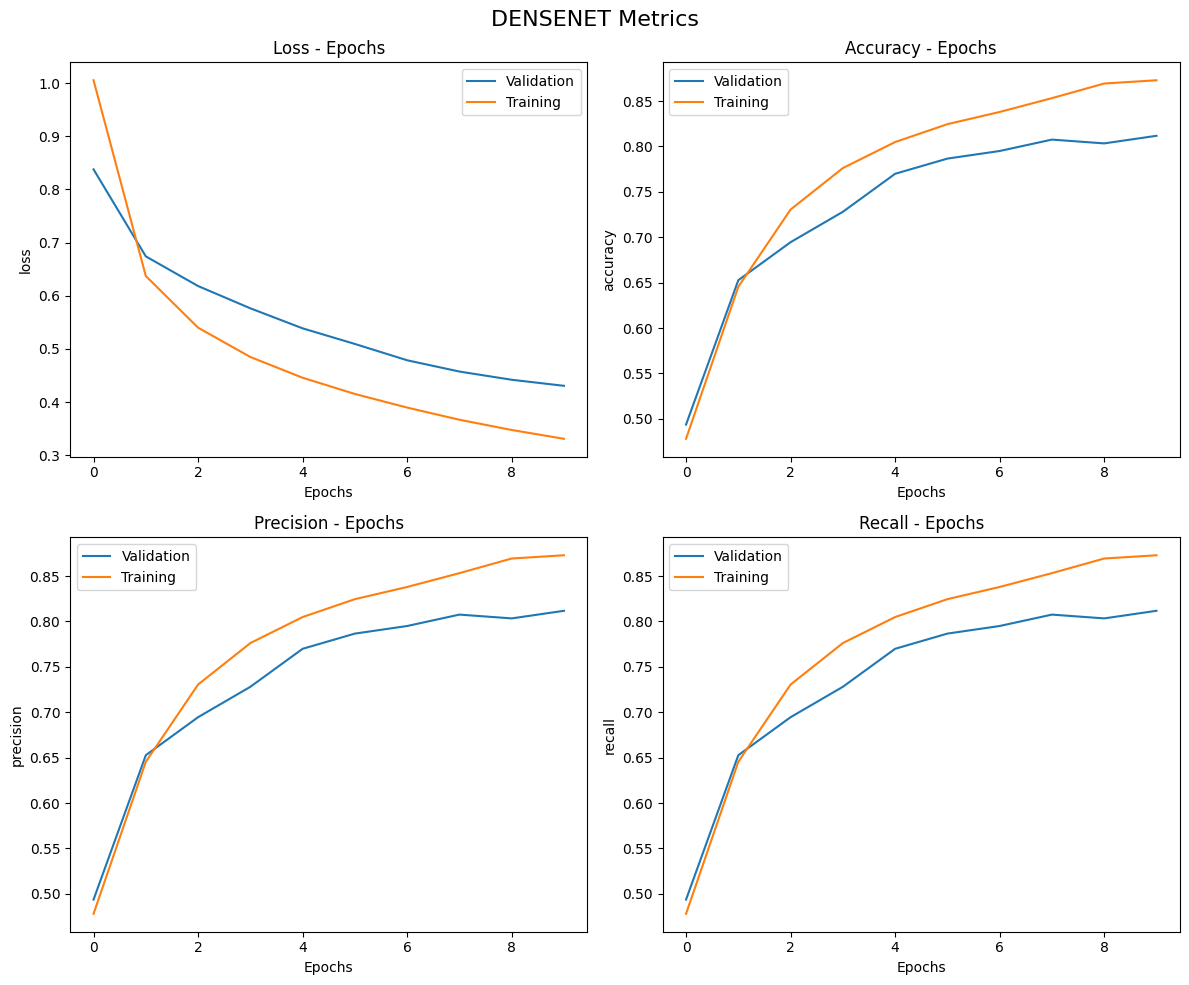

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

models = ["VGG","restnet","densenet"]
#models = ["VGG3"]
current_model = 0

def get_graph(model):
    history_df = pd.read_csv(r'outputs\training_history_'+str(model)+".csv")

    test_metrics = history_df[['val_loss', 'val_accuracy', 'val_precision', 'val_recall']]
    train_metrics = history_df[['loss', 'accuracy', 'precision', 'recall']]

    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    plt.suptitle(str(model).upper()+' Metrics', fontsize=16)

    for i, metric in enumerate(metrics, start=1):
        plt.subplot(2, 2, i)
        plt.plot(test_metrics['val_' + metric], label='Validation')
        plt.plot(train_metrics[metric], label='Training')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.title(metric.capitalize() + ' - Epochs')

    plt.tight_layout()
    plt.savefig("outputs//"+str(model)+"_history.jpg")
    plt.show()
    
for model in models:
    get_graph(model)


# Inferencias

### VGG pretrained
#### Inferencia testigo sin finetuning

Las imagenes con numeros corresponden a la clase 1 y las que comienzan con _ a la clase 0

In [147]:
#instanciar modelo con pesos preentrenados
class_names = ['class1', 'class0']
num_classes = len(class_names)

# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_v = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [151]:
#inference over non trained VGG16
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_v, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 181ms/step
1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 159ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 152ms/step
3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 157ms/step
4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 168ms/step
5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 165ms/step
6.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 172ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 153ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 155ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 155ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 157ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] -

### Finetuned VGG16 

In [148]:
#inference over custom VGG16
#instanciar modelo y cargar pesos
class_names = ['class1', 'class0']
num_classes = len(class_names)

# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_v_c = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

# Load weights
model_v_c.load_weights('weights/vgg16_weights_0.h5')




In [145]:
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_v_c, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 287ms/step
1.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 150ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 161ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 149ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 148ms/step
5.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 148ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 149ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 145ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 149ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 145ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 151ms/step
_5.jpeg -> Predicted Class: class1
1/1 [==============================] -

## Restnet Test

### Pretained Resnet

In [124]:
#check restent pretrained weights 
num_classes = 2  
# Loading ResNet50 model
base_model_restnet = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_restnet.trainable = False  

global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_r = models.Sequential([
    base_model_restnet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_r.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_r, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")

1/1 [==============================] - 4s 4s/step
1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 218ms/step
2.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 397ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 213ms/step
4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 385ms/step
5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 389ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 309ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 304ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 280ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 295ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 380ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s

### Finetuned Resnet

In [123]:
#check restnet custom weights
num_classes = 2 
base_model_restnet = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_restnet.trainable = False  

global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_r = models.Sequential([
    base_model_restnet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_r.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)


model_r.load_weights('weights/restnet_weights_0.h5')

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_r, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")


1/1 [==============================] - 2s 2s/step
1.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 253ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 236ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 349ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 207ms/step
5.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 317ms/step
6.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 195ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 243ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 215ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 214ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 258ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s

## Densenet Test

### Denset Pretrained

In [20]:
num_classes = 2 

# Loading DenseNet121 model with default ImageNet weights
base_model_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_densenet.trainable = False  

global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_d = models.Sequential([
    base_model_densenet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# model_d.load_weights('weights/densenet_weights_0.h5')
class_names = ["Class_0", "Class_1"]

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_d, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")


1/1 [==============================] - 4s 4s/step
1.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 344ms/step
2.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 387ms/step
3.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 315ms/step
4.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 270ms/step
5.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 335ms/step
6.jpeg -> Predicted Class: Class_1
1/1 [==============================] - 0s 350ms/step
_1.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 347ms/step
_2.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 261ms/step
_3.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 261ms/step
_4.jpeg -> Predicted Class: Class_0
1/1 [==============================] - 0s 333ms/step
_5.jpeg -> Predicted Class: Class_0
1/1 [=========================

### Densenet Finetuned

In [154]:
#outside test densetnet finetuned
num_classes = 2  

base_model_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model_densenet.trainable = False 

global_average_layer = layers.GlobalAveragePooling2D()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

model_d = models.Sequential([
    base_model_densenet,
    global_average_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

model_d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Load wights
model_d.load_weights('weights/densenet_weights_0.h5')

folder_path = "outside_test/256"

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        img_path = os.path.join(folder_path, filename)
        predicted_class = predict_image_class(img_path, model_d, class_names)
        print(f"{filename} -> Predicted Class: {predicted_class}")


1/1 [==============================] - 2s 2s/step
1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 141ms/step
2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 136ms/step
3.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 135ms/step
4.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 134ms/step
5.jpeg -> Predicted Class: class1
1/1 [==============================] - 0s 138ms/step
6.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 138ms/step
_1.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 130ms/step
_2.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 142ms/step
_3.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 136ms/step
_4.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s 138ms/step
_5.jpeg -> Predicted Class: class0
1/1 [==============================] - 0s

## test metrics

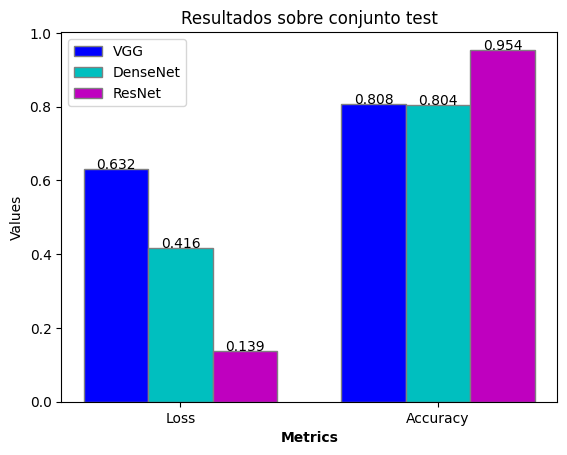

In [59]:
#test metrics 

import matplotlib.pyplot as plt
import numpy as np

metrics = ['Loss', 'Accuracy']
vgg = [0.6319921016693115, 0.8083333373069763]
densenet = [0.41629886627197266,0.8041666746139526]
resnet = [0.13863463699817657, 0.9541666507720947] 

barWidth = 0.25
r1 = np.arange(len(metrics))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.title('Resultados sobre conjunto test')

plt.bar(r1, vgg, color='b', width=barWidth, edgecolor='grey', label='VGG')
plt.bar(r2, densenet, color='c', width=barWidth, edgecolor='grey', label='DenseNet')
plt.bar(r3, resnet, color='m', width=barWidth, edgecolor='grey', label='ResNet')

plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Values')
plt.xticks([r + barWidth for r in range(len(metrics))], metrics)

for i, value in enumerate(vgg):
    plt.text(r1[i], value, str(round(value, 3)), ha='center', fontsize=10)

for i, value in enumerate(densenet):
    plt.text(r2[i], value, str(round(value, 3)), ha='center', fontsize=10)

for i, value in enumerate(resnet):
    plt.text(r3[i], value, str(round(value, 3)), ha='center', fontsize=10)

plt.legend()

plt.show()


In [91]:
#times
vgg_times = {
  "vgg_train": {
    "Epoch1": "212s",
    "Epoch2": "219s",
    "Epoch3": "219s",
    "Epoch4": "218s",
    "Epoch5": "236s",
    "Epoch6": "394s",
    "Epoch7": "397s",
    "Epoch8": "399s",
    "Epoch9": "398s",
    "Epoch10": "396s"
  },
  "vgg_outside_test": {
    "1.jpeg": "147ms",
    "2.jpeg": "149ms",
    "3.jpeg": "154ms",
    "4.jpeg": "148ms",
    "5.jpeg": "152ms",
    "6.jpeg": "147ms",
    "_1.jpeg": "150ms",
    "_2.jpeg": "153ms",
    "_3.jpeg": "154ms",
    "_4.jpeg": "148ms",
    "_5.jpeg": "148ms",
    "_6.jpeg": "149ms"
  }
}

restnet_times = {
  "retNet_train": {
    "Epoch1": "110s",
    "Epoch2": "103s",
    "Epoch3": "103s",
    "Epoch4": "103s",
    "Epoch5": "104s",
    "Epoch6": "105s",
    "Epoch7": "105s",
    "Epoch8": "105s",
    "Epoch9": "105s",
    "Epoch10": "105s"
  },
  "retNet_outside_test": {
    "1.jpeg": "321ms",
    "2.jpeg": "300ms",
    "3.jpeg": "375ms",
    "4.jpeg": "296ms",
    "5.jpeg": "225ms",
    "6.jpeg": "376ms",
    "_1.jpeg": "355ms",
    "_2.jpeg": "392ms",
    "_3.jpeg": "426ms",
    "_4.jpeg": "375ms",
    "_5.jpeg": "349ms",
    "_6.jpeg": "296ms"
  }
}
    
densenet_times = {
  "desdenet_train": {
    "Epoch1": "173s",
    "Epoch2": "155s",
    "Epoch3": "106s",
    "Epoch4": "109s",
    "Epoch5": "120s",
    "Epoch6": "112s",
    "Epoch7": "114s",
    "Epoch8": "114s",
    "Epoch9": "114s",
    "Epoch10": "114s"
  },
  "desdenet_outside_test": {
    "1.jpeg": "136ms",
    "2.jpeg": "136ms",
    "3.jpeg": "127ms",
    "4.jpeg": "133ms",
    "5.jpeg": "148ms",
    "6.jpeg": "143ms",
    "_1.jpeg": "145ms",
    "_2.jpeg": "147ms",
    "_3.jpeg": "148ms",
    "_4.jpeg": "146ms",
    "_5.jpeg": "159ms",
    "_6.jpeg": "147ms"
  }
}


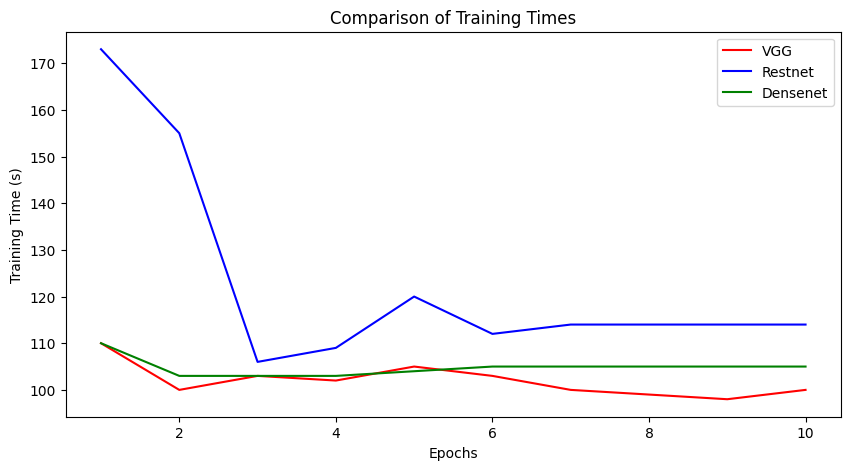

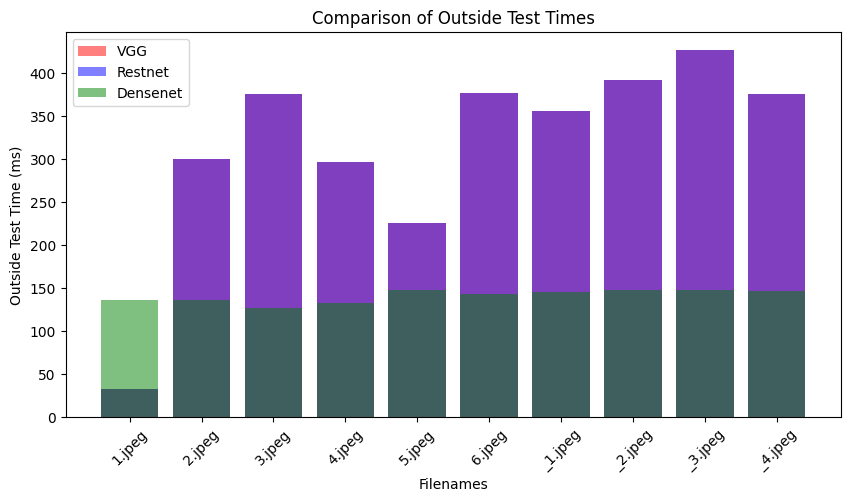

In [84]:
import matplotlib.pyplot as plt

vgg_train_times = [110, 100, 103, 102, 105, 103, 100, 99, 98, 100]
restnet_train_times = [173, 155, 106, 109, 120, 112, 114, 114, 114, 114]
densenet_train_times = [110, 103, 103, 103, 104, 105, 105, 105, 105, 105]

vgg_test_times = [32, 300, 375, 296, 225, 376, 355, 392, 426, 375]
restnet_test_times = [32, 300, 375, 296, 225, 376, 355, 392, 426, 375]
densenet_test_times = [136, 136, 127, 133, 148, 143, 145, 147, 148, 146]

epochs = [i+1 for i in range(10)]

filenames = ['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '_1.jpeg', '_2.jpeg', '_3.jpeg', '_4.jpeg']

plt.figure(figsize=(10, 5))
plt.plot(epochs, vgg_train_times, color='red', label='VGG')
plt.plot(epochs, restnet_train_times, color='blue', label='Restnet')
plt.plot(epochs, densenet_train_times, color='green', label='Densenet')
plt.xlabel('Epochs')
plt.ylabel('Training Time (s)')
plt.title('Comparison of Training Times')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(filenames, vgg_test_times, color='red', alpha=0.5, label='VGG')
plt.bar(filenames, restnet_test_times, color='blue', alpha=0.5, label='Restnet')
plt.bar(filenames, densenet_test_times, color='green', alpha=0.5, label='Densenet')
plt.xlabel('Filenames')
plt.ylabel('Outside Test Time (ms)')
plt.title('Comparison of Outside Test Times')
plt.xticks(rotation=45)
plt.legend()
plt.show()


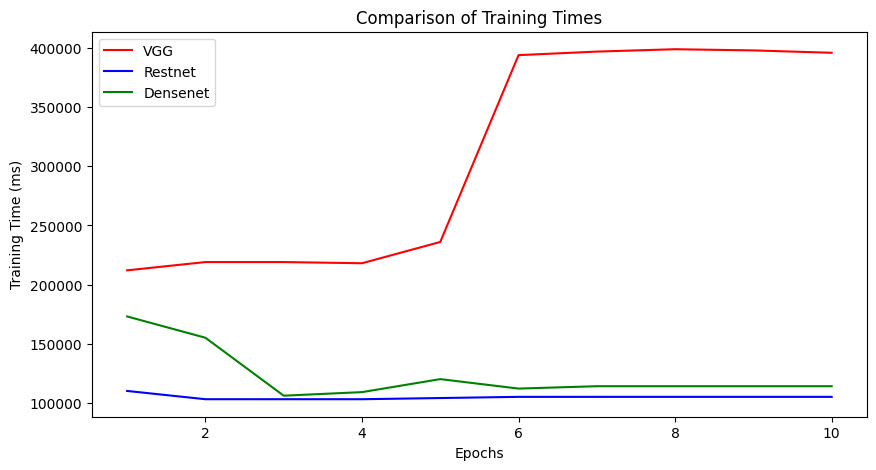

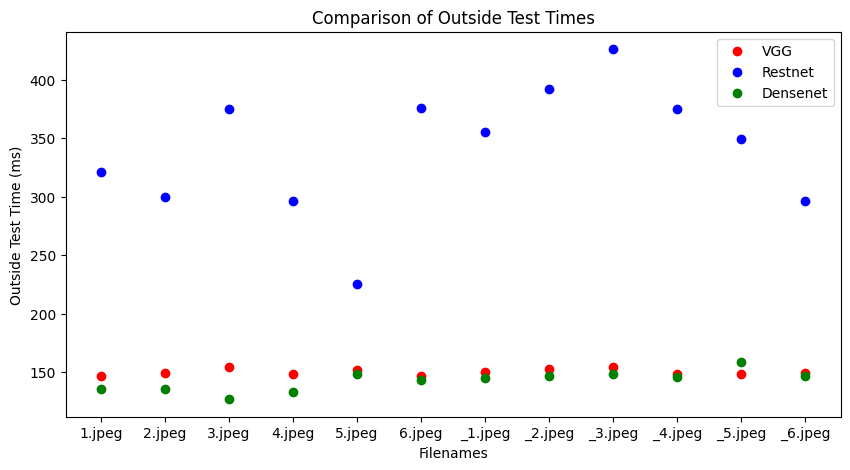

In [92]:
import matplotlib.pyplot as plt

def time_string_to_ms(time_str):
    if 'ms' in time_str:
        return int(float(time_str.replace('ms', '')))
    elif 's' in time_str:
        return int(float(time_str.replace('s', '')) * 1000)
    else:
        raise ValueError(f"Invalid time string: {time_str}")

vgg_train_times = [time_string_to_ms(vgg_times['vgg_train'][f'Epoch{i+1}']) for i in range(10)]
restnet_train_times = [time_string_to_ms(restnet_times['retNet_train'][f'Epoch{i+1}']) for i in range(10)]
densenet_train_times = [time_string_to_ms(densenet_times['desdenet_train'][f'Epoch{i+1}']) for i in range(10)]

vgg_test_times = [time_string_to_ms(time) for time in vgg_times['vgg_outside_test'].values()]
restnet_test_times = [time_string_to_ms(time) for time in restnet_times['retNet_outside_test'].values()]
densenet_test_times = [time_string_to_ms(time) for time in densenet_times['desdenet_outside_test'].values()]

epochs = [i+1 for i in range(10)]
filenames = list(vgg_times['vgg_outside_test'].keys())

plt.figure(figsize=(10, 5))
plt.plot(epochs, vgg_train_times, color='red', label='VGG')
plt.plot(epochs, restnet_train_times, color='blue', label='Restnet')
plt.plot(epochs, densenet_train_times, color='green', label='Densenet')
plt.xlabel('Epochs')
plt.ylabel('Training Time (ms)')
plt.title('Comparison of Training Times')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(filenames, vgg_test_times, color='red', label='VGG')
plt.scatter(filenames, restnet_test_times, color='blue', label='Restnet')
plt.scatter(filenames, densenet_test_times, color='green', label='Densenet')
plt.xlabel('Filenames')
plt.ylabel('Outside Test Time (ms)')
plt.title('Comparison of Outside Test Times')
plt.legend()
plt.show()

In [107]:
import pandas as pd

results_vgg = [
    ('1.jpeg', 'class1'),
    ('2.jpeg', 'class0'),
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class1'),
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class0'),
    ('_6.jpeg', 'class0')
]

df_vgg = pd.DataFrame(results_vgg, columns=['Image', 'Predicted_Class'])
df_vgg['True_Label'] = df_vgg['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
print("VGG"
)
print(df_vgg)

results_resnet = [
    ('1.jpeg', 'class1'),
    ('2.jpeg', 'class0'),
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class1'),
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class1'),  # diferencia
    ('_6.jpeg', 'class0')
]

df_resnet = pd.DataFrame(results_resnet, columns=['Image', 'Predicted_Class'])
df_resnet['True_Label'] = df_resnet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')

print(" ")
print("ResNet")
print(df_resnet)

import pandas as pd

results_densenet = [
    ('1.jpeg', 'class0'),
    ('2.jpeg', 'class1'),
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class0'),
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class0'),
    ('_6.jpeg', 'class0')
]

df_densenet = pd.DataFrame(results_densenet, columns=['Image', 'Predicted_Class'])

df_densenet['True_Label'] = df_densenet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')

print(" ")
print("DenseNet")
print(df_densenet)


VGG
      Image Predicted_Class True_Label
0    1.jpeg          class1     class1
1    2.jpeg          class0     class1
2    3.jpeg          class1     class1
3    4.jpeg          class1     class1
4    5.jpeg          class1     class1
5    6.jpeg          class1     class1
6   _1.jpeg          class0     class0
7   _2.jpeg          class0     class0
8   _3.jpeg          class0     class0
9   _4.jpeg          class0     class0
10  _5.jpeg          class0     class0
11  _6.jpeg          class0     class0
 
ResNet
      Image Predicted_Class True_Label
0    1.jpeg          class1     class1
1    2.jpeg          class0     class1
2    3.jpeg          class1     class1
3    4.jpeg          class1     class1
4    5.jpeg          class1     class1
5    6.jpeg          class1     class1
6   _1.jpeg          class0     class0
7   _2.jpeg          class0     class0
8   _3.jpeg          class0     class0
9   _4.jpeg          class0     class0
10  _5.jpeg          class1     class0
11  _6.jpeg 

In [114]:
import pandas as pd

def calculate_metrics(df):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for index, row in df.iterrows():
        if row['True_Label'] == 'class1' and row['Predicted_Class'] == 'class1':
            TP += 1
        elif row['True_Label'] == 'class0' and row['Predicted_Class'] == 'class0':
            TN += 1
        elif row['True_Label'] == 'class1' and row['Predicted_Class'] == 'class0':
            FN += 1
        elif row['True_Label'] == 'class0' and row['Predicted_Class'] == 'class1':
            FP += 1

    return TP, TN, FP, FN

# VGG
df_vgg = pd.DataFrame(results_vgg, columns=['Image', 'Predicted_Class'])
df_vgg['True_Label'] = df_vgg['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
print("VGG")
print(df_vgg)
TP, TN, FP, FN = calculate_metrics(df_vgg)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# ResNet
df_resnet = pd.DataFrame(results_resnet, columns=['Image', 'Predicted_Class'])
df_resnet['True_Label'] = df_resnet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
print("\nResNet")
print(df_resnet)
TP, TN, FP, FN = calculate_metrics(df_resnet)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# DenseNet
df_densenet = pd.DataFrame(results_densenet, columns=['Image', 'Predicted_Class'])
df_densenet['True_Label'] = df_densenet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
print("\nDenseNet")
print(df_densenet)
TP, TN, FP, FN = calculate_metrics(df_densenet)
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


VGG
      Image Predicted_Class True_Label
0    1.jpeg          class1     class1
1    2.jpeg          class0     class1
2    3.jpeg          class1     class1
3    4.jpeg          class1     class1
4    5.jpeg          class1     class1
5    6.jpeg          class1     class1
6   _1.jpeg          class0     class0
7   _2.jpeg          class0     class0
8   _3.jpeg          class0     class0
9   _4.jpeg          class0     class0
10  _5.jpeg          class0     class0
11  _6.jpeg          class0     class0
TP: 5, TN: 6, FP: 0, FN: 1

ResNet
      Image Predicted_Class True_Label
0    1.jpeg          class1     class1
1    2.jpeg          class0     class1
2    3.jpeg          class1     class1
3    4.jpeg          class1     class1
4    5.jpeg          class1     class1
5    6.jpeg          class1     class1
6   _1.jpeg          class0     class0
7   _2.jpeg          class0     class0
8   _3.jpeg          class0     class0
9   _4.jpeg          class0     class0
10  _5.jpeg          clas

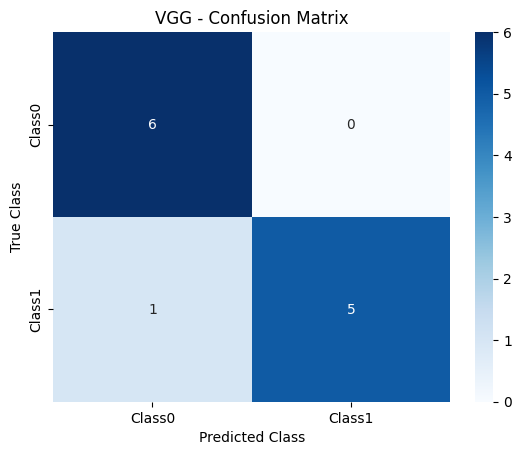

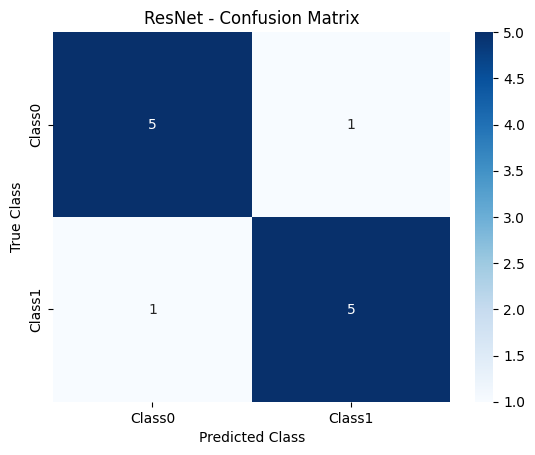

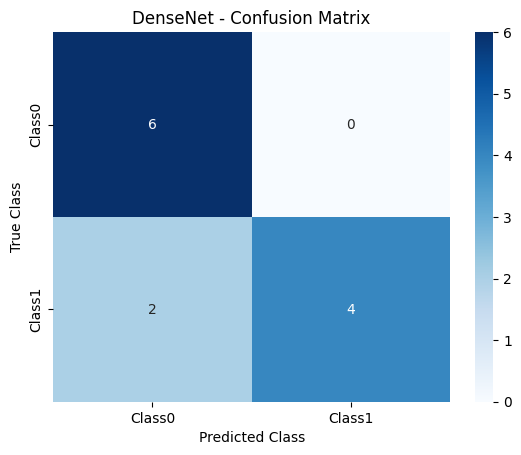

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(df):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for index, row in df.iterrows():
        if row['True_Label'] == 'class1' and row['Predicted_Class'] == 'class1':
            TP += 1
        elif row['True_Label'] == 'class0' and row['Predicted_Class'] == 'class0':
            TN += 1
        elif row['True_Label'] == 'class1' and row['Predicted_Class'] == 'class0':
            FN += 1
        elif row['True_Label'] == 'class0' and row['Predicted_Class'] == 'class1':
            FP += 1

    return TP, TN, FP, FN

def plot_confusion_matrix(TP, TN, FP, FN, model_name):
    conf_matrix = [[TN, FP], [FN, TP]]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class0', 'Class1'], yticklabels=['Class0', 'Class1'])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

results_vgg = [
    ('1.jpeg', 'class1'),
    ('2.jpeg', 'class0'),
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class1'),
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class0'),
    ('_6.jpeg', 'class0')
]
df_vgg = pd.DataFrame(results_vgg, columns=['Image', 'Predicted_Class'])
df_vgg['True_Label'] = df_vgg['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
TP, TN, FP, FN = calculate_metrics(df_vgg)
plot_confusion_matrix(TP, TN, FP, FN, 'VGG')

results_resnet = [
    ('1.jpeg', 'class1'),
    ('2.jpeg', 'class0'),
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class1'),
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class1'),  # diferencia
    ('_6.jpeg', 'class0')
]
df_resnet = pd.DataFrame(results_resnet, columns=['Image', 'Predicted_Class'])
df_resnet['True_Label'] = df_resnet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
TP, TN, FP, FN = calculate_metrics(df_resnet)
plot_confusion_matrix(TP, TN, FP, FN, 'ResNet')

results_densenet = [
    ('1.jpeg', 'class0'), #dif
    ('2.jpeg', 'class1'), #dif
    ('3.jpeg', 'class1'),
    ('4.jpeg', 'class1'),
    ('5.jpeg', 'class0'), #dif
    ('6.jpeg', 'class1'),
    ('_1.jpeg', 'class0'),
    ('_2.jpeg', 'class0'),
    ('_3.jpeg', 'class0'),
    ('_4.jpeg', 'class0'),
    ('_5.jpeg', 'class0'), #dif
    ('_6.jpeg', 'class0')
]
df_densenet = pd.DataFrame(results_densenet, columns=['Image', 'Predicted_Class'])
df_densenet['True_Label'] = df_densenet['Image'].apply(lambda x: 'class0' if x.startswith('_') else 'class1')
TP, TN, FP, FN = calculate_metrics(df_densenet)
plot_confusion_matrix(TP, TN, FP, FN, 'DenseNet')


8/8 [==============================] - 35s 4s/step


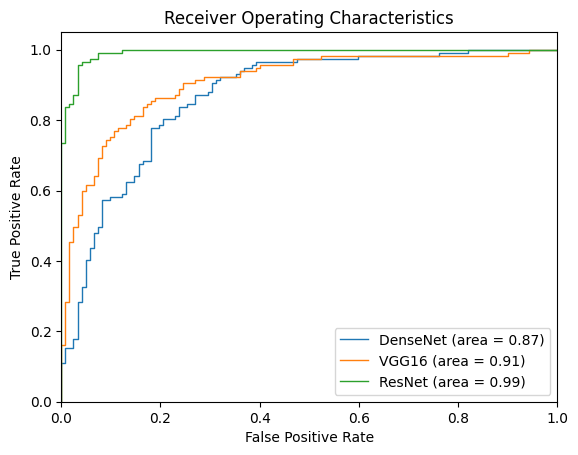

In [126]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

model_d.load_weights('weights\\densenet_weights_3.h5')
model_v_c.load_weights('weights\\vgg16_weights_1.h5')
model_r.load_weights('weights\\restnet_weights_2.h5')

true_labels = np.concatenate([y for x, y in val_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)
true_labels_binary = (true_labels == 1).astype(int)  

plt.figure()

def evaluate_and_plot_roc(model, val_dataset, label_name):
    predictions = model.predict(val_dataset)
    predicted_probabilities = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels_binary, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'{label_name} (area = %0.2f)' % roc_auc)

evaluate_and_plot_roc(model_d, val_dataset, 'DenseNet')
evaluate_and_plot_roc(model_v_c, val_dataset, 'VGG16')
evaluate_and_plot_roc(model_r, val_dataset, 'ResNet')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics Val')
plt.legend(loc="lower right")

plt.show()


8/8 [==============================] - 37s 5s/step


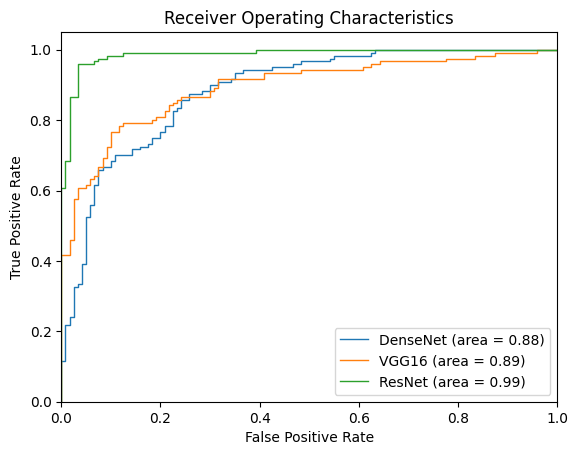

In [125]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

model_d.load_weights('weights\\densenet_weights_3.h5')
model_v_c.load_weights('weights\\vgg16_weights_1.h5')
model_r.load_weights('weights\\restnet_weights_2.h5')

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)
true_labels_binary = (true_labels == 1).astype(int)  # Rverse one hot

plt.figure()
def evaluate_and_plot_roc(model, dataset, label_name):
    predictions = model.predict(dataset)
    predicted_probabilities = predictions[:, 1]
    fpr, tpr, _ = roc_curve(true_labels_binary, predicted_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'{label_name} (area = %0.2f)' % roc_auc)

evaluate_and_plot_roc(model_d, test_dataset, 'DenseNet')
evaluate_and_plot_roc(model_v_c, test_dataset, 'VGG16')
evaluate_and_plot_roc(model_r, test_dataset, 'ResNet')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics Test')
plt.legend(loc="lower right")
plt.show()


8/8 [==============================] - 73s 9s/step


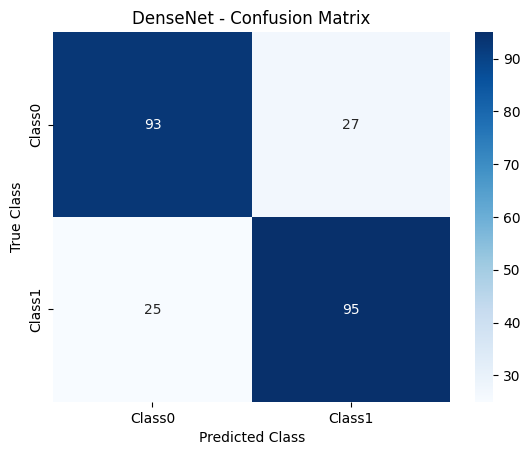

8/8 [==============================] - 231s 29s/step


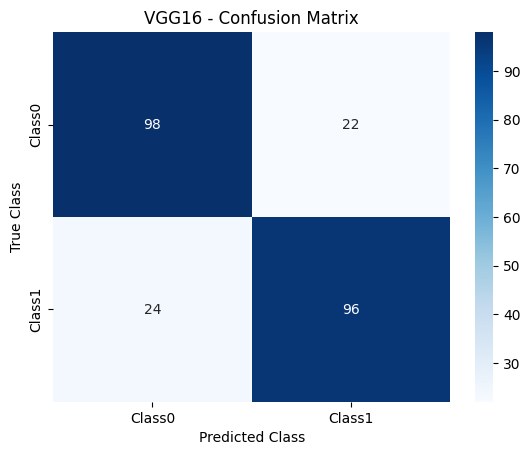

8/8 [==============================] - 68s 8s/step


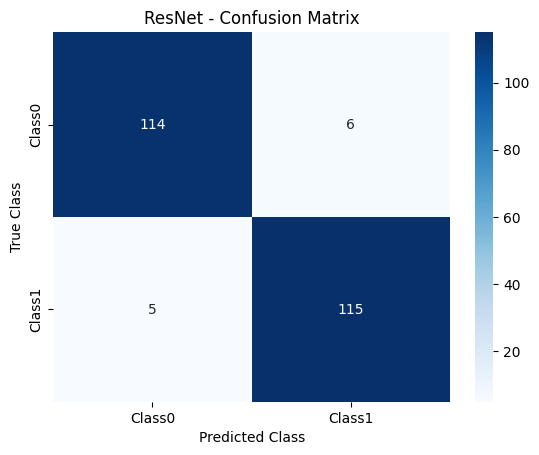

In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

def evaluate_and_plot_confusion_matrix(model, dataset, label_name):
    predictions = model.predict(dataset)
    
    predicted_labels = np.argmax(predictions, axis=1)
    
    conf_mat = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Class0', 'Class1'], yticklabels=['Class0', 'Class1'])
    plt.title(f"{label_name} - Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

model_d.load_weights('weights\\densenet_weights_3.h5')
model_v_c.load_weights('weights\\vgg16_weights_1.h5')
model_r.load_weights('weights\\restnet_weights_2.h5')

true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
true_labels = np.argmax(true_labels, axis=1)

evaluate_and_plot_confusion_matrix(model_d, test_dataset, 'DenseNet')
evaluate_and_plot_confusion_matrix(model_v_c, test_dataset, 'VGG16')
evaluate_and_plot_confusion_matrix(model_r, test_dataset, 'ResNet')
